# World Wide Products Inc.

TODO Write intro

## Retrieving the Data
This data comes from the [Forecasts for Product Demand dataset on Kaggle](https://www.kaggle.com/felixzhao/productdemandforecasting). We will begin by loading the dataset into a dataframe:

In [89]:
from os import path
import numpy as np
import pandas as pd

product_demand_df = pd.read_csv("data/raw/Historical Product Demand.csv")
product_demand_df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Let's run through some quick information about this dataset:

In [90]:
product_demand_df.shape

(1048575, 5)

In [91]:
product_demand_df.keys()

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In order to effectively use this dataset, let's analyze the columns:

|Key              |Description|
|:----------------|:----------|
|Product_Code     |Product name, encoded|
|Warehouse        |Warehouse name, encoded|
|Product_Category |Category for each product, encoded|
|Date             |Date customer needs the product|
|Order_Demand     |Single order quantity|

## Cleaning Up the Data
There are some very simple things we can do to start cleaning the data. First, let's make the columns lowercase, just for consistency sake:

In [92]:
product_demand_df.columns = map(str.lower, product_demand_df.columns)
product_demand_df.keys()

Index(['product_code', 'warehouse', 'product_category', 'date',
       'order_demand'],
      dtype='object')

Let's check for any missing values:

In [93]:
product_demand_df[product_demand_df.isna().any(axis=1)]

,product_code,warehouse,product_category,date,order_demand
45460,Product_1461,Whse_A,Category_019,NaN,10000
456373,Product_1636,Whse_A,Category_019,NaN,100
456374,Product_1461,Whse_A,Category_019,NaN,300
456375,Product_1464,Whse_A,Category_019,NaN,300
456376,Product_1388,Whse_A,Category_019,NaN,200
...,...,...,...,...,...
995790,Product_1464,Whse_A,Category_019,NaN,(900)
995791,Product_1541,Whse_A,Category_019,NaN,(200)
995792,Product_1388,Whse_A,Category_019,NaN,(300)
995793,Product_1541,Whse_A,Category_019,NaN,(300)


It looks like we have a bunch of missing dates. Because we are doing time series forecasting, we require a date. Let's go ahead and drop all of these data points, as they are unusable to us.

In [94]:
indices_to_drop = product_demand_df[product_demand_df.isna().any(axis=1)].index
product_demand_df.drop(indices_to_drop, inplace=True)

Next, let's convert all of the information in `product_code`, `warehouse`, and `product_category` to integers:

In [95]:
unique_products = product_demand_df["product_code"].unique()
product_ordinal = {v: k for k, v in dict(enumerate(unique_products.flatten(), 1)).items()}
product_demand_df["product_code_ordinal"] = product_demand_df["product_code"].apply(lambda p: product_ordinal[p])

unique_warehouses = product_demand_df["warehouse"].unique()
warehouse_ordinal = {v: k for k, v in dict(enumerate(unique_warehouses.flatten(), 1)).items()}
product_demand_df["warehouse_ordinal"] = product_demand_df["warehouse"].apply(lambda w: warehouse_ordinal[w])

unique_categories = product_demand_df["product_category"].unique()
category_ordinal = {v: k for k, v in dict(enumerate(unique_categories.flatten(), 1)).items()}
product_demand_df["product_category_ordinal"] = product_demand_df["product_category"].apply(lambda c: category_ordinal[c])

product_demand_df.head()

,product_code,warehouse,product_category,date,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal
0,Product_0993,Whse_J,Category_028,2012/7/27,100,1,1,1
1,Product_0979,Whse_J,Category_028,2012/1/19,500,2,1,1
2,Product_0979,Whse_J,Category_028,2012/2/3,500,2,1,1
3,Product_0979,Whse_J,Category_028,2012/2/9,500,2,1,1
4,Product_0979,Whse_J,Category_028,2012/3/2,500,2,1,1


We also have an issue with our `order_demand` values. They are stored as strings, and almost all have something wrong with them:

In [96]:
# Prints all demands that are not numeric strings
product_demand_df["order_demand"][~product_demand_df["order_demand"].str.isnumeric()].shape

(1037336,)

**1037336** of our order demand values are in string form, rather than integers! Let's change that:

In [97]:
import re

# Extract all integers and save them
product_demand_df["order_demand"] = product_demand_df["order_demand"].apply(lambda x: int(re.findall(r"\d+", x)[0]))

Finally, let's convert all dates to `datetime` objects. From taking a look at the `date` values in a previous statement, it looks like the pattern is "_year/month/day_":

In [98]:
product_demand_df["date"] = pd.to_datetime(product_demand_df["date"], format="%Y/%m/%d")
product_demand_df["date"].describe()

count                 1037336
unique                   1729
top       2013-09-27 00:00:00
freq                     2075
first     2011-01-08 00:00:00
last      2017-01-09 00:00:00
Name: date, dtype: object

## Feature Engineering
To predict the demad of a specific product, we should make some new features that make that job easier. To do this, let's organize things by `product`, and create a new feature that specifies the `demand_per_month`

To start, let's split the date into a `months_since_start` integer to make `demand_per_month` calculations easier. We'll also do the `days_since_start` to test accuracy:

In [99]:
# Check if we have already processed the data:
if not path.exists("data/processed/product_demand_cleaned.csv"):
    
    # Get start date
    date_start = product_demand_df["date"].min()

    # Calculate days since start
    product_demand_df["days_since_start"] = product_demand_df["date"].apply(lambda date: (date - date_start).days)

    # Calculate months since start
    product_demand_df["months_since_start"] = product_demand_df["date"]\
        .apply(lambda date: ((date.year - date_start.year) * 12) + (date.month - date_start.month))

    # We don't need this date column anymore
    product_demand_df.drop(columns=["date"], inplace=True)

    # Save the cleaned data to a csv file
    product_demand_df.to_csv("data/processed/product_demand_cleaned.csv")
else:
    product_demand_df = pd.read_csv("data/processed/product_demand_cleaned.csv")
    product_demand_df.drop(product_demand_df.columns[0], axis=1, inplace=True) # Get rid of index column

product_demand_df.head()

,product_code,warehouse,product_category,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal,days_since_start,months_since_start
0,Product_0993,Whse_J,Category_028,100,1,1,1,566,18
1,Product_0979,Whse_J,Category_028,500,2,1,1,376,12
2,Product_0979,Whse_J,Category_028,500,2,1,1,391,13
3,Product_0979,Whse_J,Category_028,500,2,1,1,397,13
4,Product_0979,Whse_J,Category_028,500,2,1,1,419,14


Before we do the per month calculations, let's check the standard deviation of each product. This will help us later on down the line:

In [100]:
standard_deviations = product_demand_df.groupby("product_code")["order_demand"].std().reset_index()\
    .rename(columns={"order_demand": "product_standard_dev_day"})
standard_deviations = standard_deviations.replace(np.NaN, 0) # Make sure we have no NaN values
product_demand_df = pd.merge(product_demand_df , standard_deviations, on=["product_code"])
product_demand_df.head()

,product_code,warehouse,product_category,order_demand,product_code_ordinal,warehouse_ordinal,product_category_ordinal,days_since_start,months_since_start,product_standard_dev_day
0,Product_0993,Whse_J,Category_028,100,1,1,1,566,18,497.474763
1,Product_0993,Whse_J,Category_028,300,1,1,1,614,20,497.474763
2,Product_0993,Whse_J,Category_028,500,1,1,1,620,20,497.474763
3,Product_0993,Whse_J,Category_028,300,1,1,1,640,21,497.474763
4,Product_0993,Whse_J,Category_028,200,1,1,1,670,22,497.474763


Now let's do the per month calculations:

In [101]:
demand_products_month_df = product_demand_df[["product_code_ordinal", "months_since_start", "order_demand"]]\
    .groupby(["months_since_start", "product_code_ordinal"])["order_demand"].sum().reset_index()
# Add standard deviation feature
standard_deviations = demand_products_month_df.groupby("product_code_ordinal")["order_demand"].std().reset_index()\
    .rename(columns={"order_demand": "product_standard_dev_month"})
standard_deviations = standard_deviations.replace(np.NaN, 0) # Make sure we have no NaN values
demand_products_month_df = pd.merge(demand_products_month_df , standard_deviations, on=["product_code_ordinal"])
demand_products_month_df.head()

,months_since_start,product_code_ordinal,order_demand,product_standard_dev_month
0,0,45,2,7.681404
1,10,45,11,7.681404
2,11,45,1,7.681404
3,12,45,17,7.681404
4,13,45,29,7.681404


## Analysis
Let's start analyzing some data. Let's start by visualizing the purchases:

In [102]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

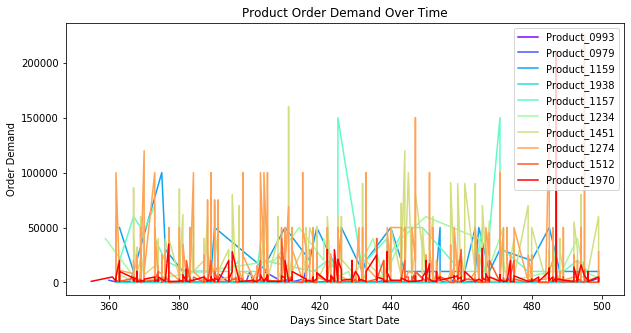

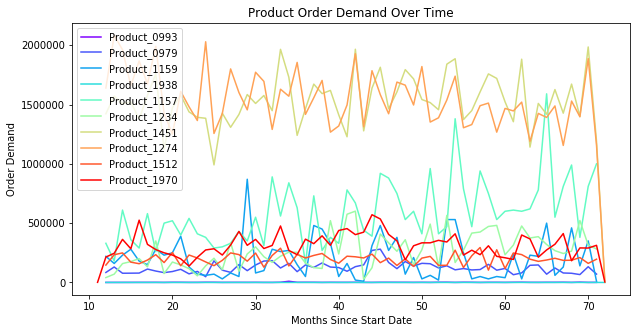

In [103]:
plt.figure(figsize=(10, 5))

num_products_shown = 10
days_shown = 500

data = product_demand_df.sort_values(by="days_since_start").loc[product_demand_df["days_since_start"] < days_shown]\
    .groupby(["product_code_ordinal"]).apply(lambda row: np.array(list(zip(row["days_since_start"], row["order_demand"]))))
data = np.array(list(data[:num_products_shown]))

colors = cm.rainbow(np.linspace(0, 1, num_products_shown))
i = 0
for d in data:
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=unique_products[i])
    i += 1
plt.title("Product Order Demand Over Time")
plt.xlabel("Days Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.figure(figsize=(10, 5))

num_products_shown = 10

data = demand_products_month_df.groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["months_since_start"], row["order_demand"]))))
data = np.array(list(data[:num_products_shown]))

i = 0
for d in data:
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=unique_products[i])
    i += 1
plt.title("Product Order Demand Over Time")
plt.xlabel("Months Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.show()

Oh boy, that's a lot of colors. Let's pick one product that ideally has a large number of data points but a low standard deviation - this will lead to the most accurate predictions:

In [156]:
products_with_most_data = product_demand_df.groupby("product_code_ordinal").size()\
    .sort_values(ascending=False)[:100].reset_index()["product_code_ordinal"].values

products_with_low_std = product_demand_df.loc[product_demand_df["product_code_ordinal"].isin(products_with_most_data)]\
    .groupby("product_code_ordinal").first()["product_standard_dev_day"]\
    .sort_values(ascending=True).reset_index()["product_code_ordinal"].values

num_viable_products = 5
viable_product_ordinals = products_with_low_std[:num_viable_products]
viable_products = product_demand_df.loc[product_demand_df["product_code_ordinal"].isin(viable_product_ordinals)]\
    .reset_index().sort_values(by="days_since_start")
viable_product_codes = viable_products.groupby("product_code_ordinal").first()["product_code"]

viable_products[["product_code", "product_code_ordinal", "product_standard_dev_day"]]\
    .groupby("product_code_ordinal").first().sort_values(by="product_standard_dev_day").head().reset_index()

,product_code_ordinal,product_code,product_standard_dev_day
0,81,Product_0613,10.577811
1,153,Product_0608,17.175626
2,151,Product_0620,21.093205
3,1377,Product_0361,23.662398
4,342,Product_0495,31.023758


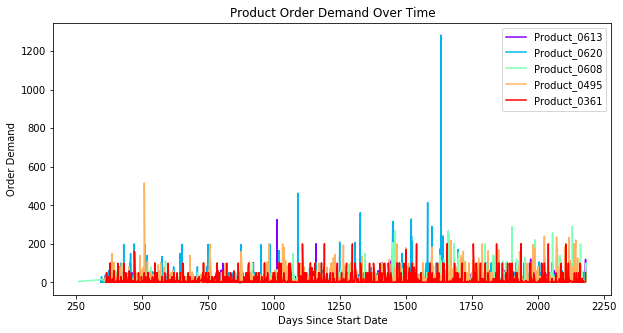

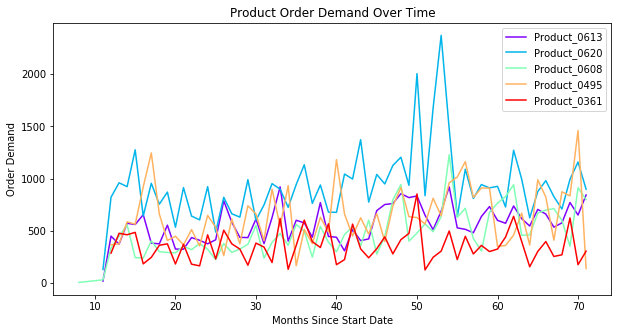

In [157]:
plt.figure(figsize=(10, 5))

data = viable_products.groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["days_since_start"], row["order_demand"], row["product_code_ordinal"]))))
data = np.array(list(data))

colors = cm.rainbow(np.linspace(0, 1, len(data)))
for i, d in enumerate(data):
    ordinal = d[0, 2]
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=viable_product_codes[ordinal])
plt.title("Product Order Demand Over Time")
plt.xlabel("Days Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.figure(figsize=(10, 5))

data = demand_products_month_df.loc[demand_products_month_df["product_code_ordinal"].isin(viable_product_ordinals)]\
    .groupby(["product_code_ordinal"])\
    .apply(lambda row: np.array(list(zip(row["months_since_start"], row["order_demand"], row["product_code_ordinal"]))))
data = np.array(list(data))

for i, d in enumerate(data):
    ordinal = d[0, 2]
    plt.plot(d[:, 0], d[:, 1], color=colors[i], label=viable_product_codes[ordinal])
plt.title("Product Order Demand Over Time")
plt.xlabel("Months Since Start Date")
plt.ylabel("Order Demand")
plt.legend()

plt.show()

That's much more readable! Let's do some predictions!

## Predicting Order Demand Using Daily Values
To do this, we will use a method called `10-fold Cross-Validation`. In this, we will use 90% of the test data as training data and the remaining 10% as test data. Then, we will fit the model again by shifting both the training data and test data by 10%, so we are training and testing over a different dataset. We will do this 10 times to get through all of the data (hence, 10-fold)

Because we are using time series, we will tweak this just a bit. Instead of training using the remaining 90% every time, we will instead increment the amount of training data, starting with 10%, then 20%, then 30%,... This way, we do not have to use future data that we have not seen yet.

In [164]:
import math
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

ten_fold_step_size = math.floor(0.10 * viable_products.shape[0])

#### Gradient Boosting

In [166]:
grad_boost = GradientBoostingRegressor()

# 10-fold cross-validation
training_length = ten_fold_step_size
while training_length < 9 * ten_fold_step_size:
    training_data = viable_products.loc[range(training_length)]
    training_data_l = training_data["order_demand"]
    training_data_f = training_data[["product_code_ordinal", "warehouse_ordinal", "product_category_ordinal", "days_since_start"]]
    grad_boost.fit(training_data_f, training_data_l)
    training_length += ten_fold_step_size

testing_data = viable_products.loc[range(9 * ten_fold_step_size, 10 * ten_fold_step_size)]
testing_data_l = testing_data["order_demand"].values
testing_data_f = testing_data[["product_code_ordinal", "warehouse_ordinal", "product_category_ordinal", "days_since_start"]]
prediction = grad_boost.predict(testing_data_f)
grad_boost_accuracy = r2_score(prediction, testing_data_l)
print("Gradient Boost r2 Score (with daily values): {}".format(grad_boost_accuracy))

Gradient Boost r2 Score (with daily values): -37.480029835529386


#### Neural Network

In [48]:
nn = MLPRegressor(max_iter=100)
nn.fit(training_f, training_l)
prediction = nn.predict(testing_f)
nn.score(testing_f, testing_l)

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.0479564169770722